In [1]:
!pip install -e ../.

Defaulting to user installation because normal site-packages is not writeable
Obtaining file:///Users/mayanknautiyal/Desktop/Codes/CVAEI
  Preparing metadata (setup.py) ... done
  Running setup.py develop for cvaei


In [2]:
import sys
sys.path.insert(0, '../')  


In [3]:
%pwd


'/Users/mayanknautiyal/Desktop/Codes/CVAEI/notebooks'

In [4]:
import cvaei
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from torch import nn, optim
from cvaei.examples.villar import Villar
from cvaei.models.conv_cvae import CNN_CVAE
import multiprocessing as mp


device = torch.device("cpu" if torch.cuda.is_available() else "cpu")
# print("Using device:", device)
# print(torch.cuda.is_available())
# print(torch.version.cuda)



In [5]:
villar = Villar()
mp.set_start_method('spawn')
train_theta_norm, train_data_norm, theta_normalizer, data_normalizer, val_theta_norm, val_data_norm = villar.prepare_data(10, scale = True)
observed_data = villar.observed_data()
#villar.check_normalizer()

Generating data...
Number of CPU cores being used: 6


Training Theta Shape: torch.Size([10, 15])
Training Data Shape: torch.Size([10, 3, 200])
Generating data...
Number of CPU cores being used: 6
Validation Theta Shape: torch.Size([4, 15])
Validation Data Shape: torch.Size([4, 3, 200])
torch.Size([1, 3, 200])


In [6]:
train_data_norm[3]

tensor([[0.0000e+00, 2.7258e-02, 1.3950e-01, 2.9396e-01, 5.1042e-01, 7.5735e-01,
         8.6692e-01, 4.1368e-01, 2.3891e-01, 1.7424e-01, 1.3576e-01, 1.7638e-01,
         1.4003e-01, 1.4484e-01, 1.4591e-01, 1.4858e-01, 2.3356e-01, 1.8813e-01,
         1.2133e-01, 1.2079e-01, 1.2827e-01, 1.3629e-01, 1.1010e-01, 9.1929e-02,
         2.0898e-01, 2.9984e-01, 4.3987e-01, 6.2533e-01, 8.1026e-01, 6.6756e-01,
         3.3030e-01, 1.9188e-01, 2.1272e-01, 1.6622e-01, 1.1438e-01, 1.3950e-01,
         1.2026e-01, 1.4591e-01, 1.4164e-01, 1.4431e-01, 2.3036e-01, 2.8274e-01,
         3.0572e-01, 3.9230e-01, 5.3127e-01, 6.7771e-01, 6.7825e-01, 3.4046e-01,
         2.3677e-01, 1.5446e-01, 1.4057e-01, 1.3736e-01, 1.7157e-01, 1.4912e-01,
         8.1240e-02, 1.6355e-01, 1.5660e-01, 1.1384e-01, 1.3362e-01, 1.4270e-01,
         9.8878e-02, 2.0524e-01, 2.5067e-01, 3.6237e-01, 5.2378e-01, 7.0016e-01,
         8.7226e-01, 8.9792e-01, 4.0941e-01, 2.1005e-01, 1.7531e-01, 1.3362e-01,
         1.3308e-01, 1.9027e

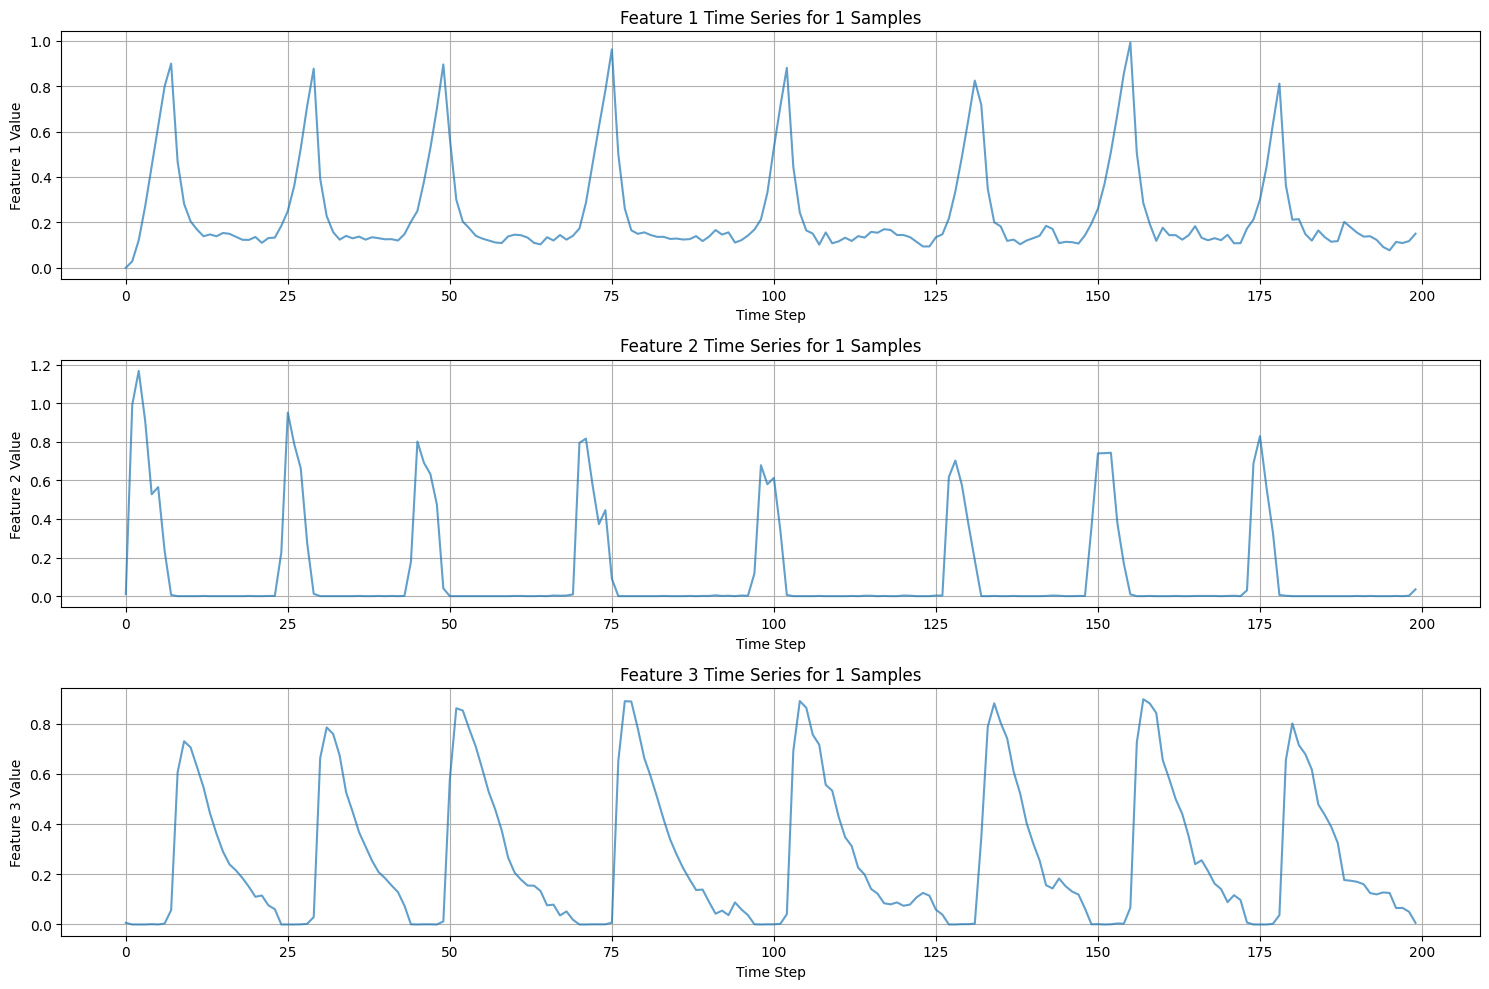

In [7]:
villar.plot_observation(observed_data)

# Initialise the Model

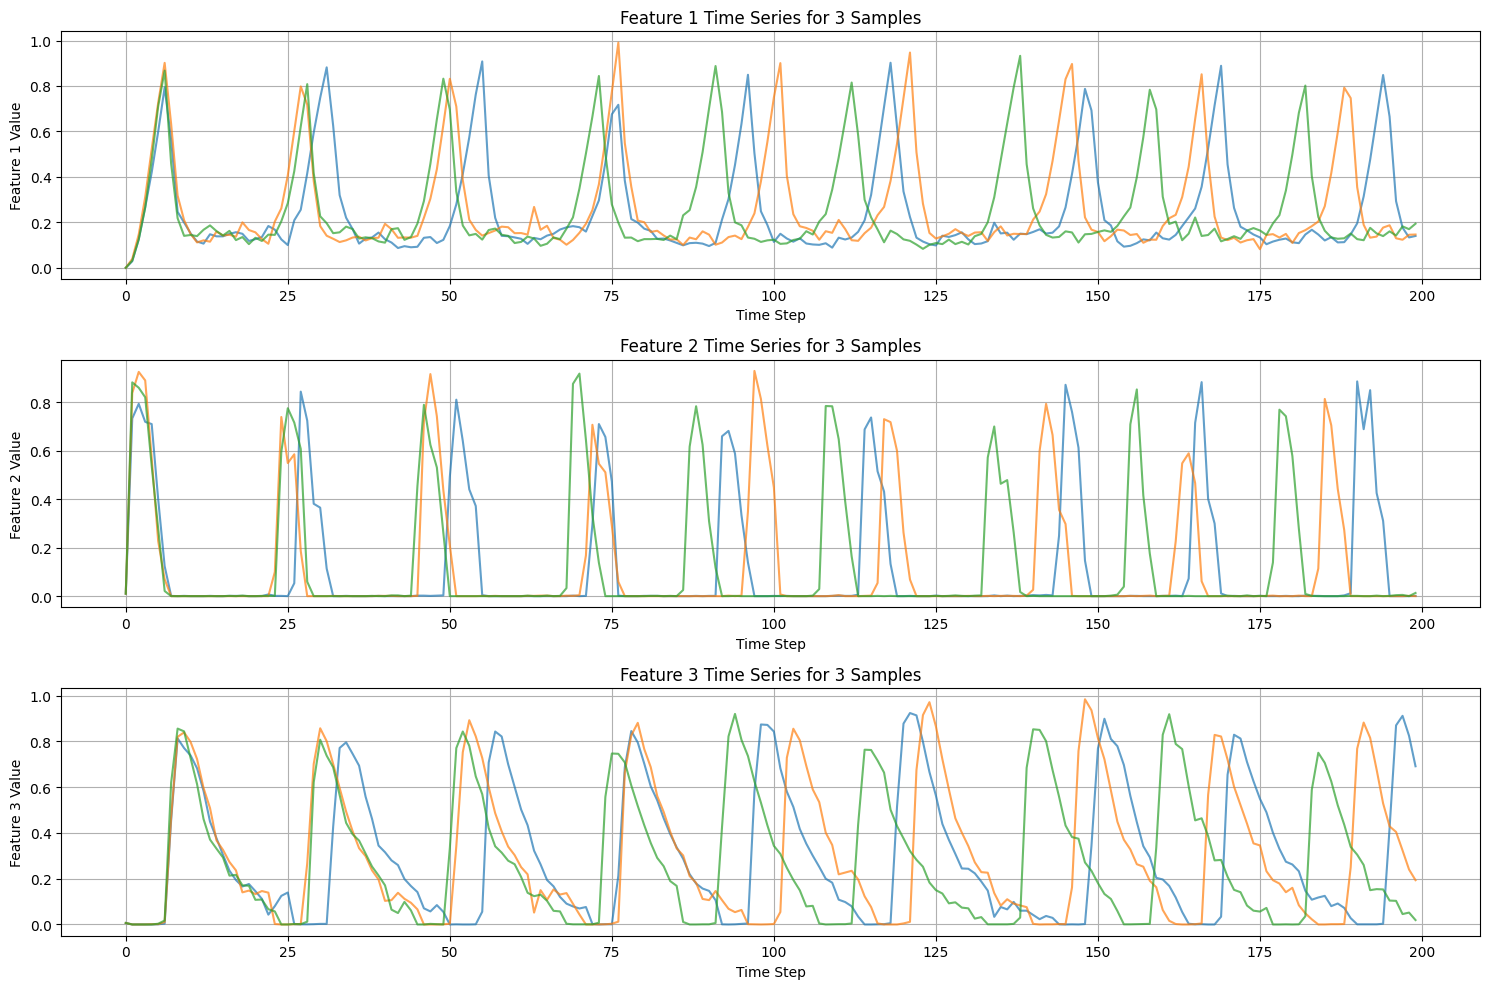

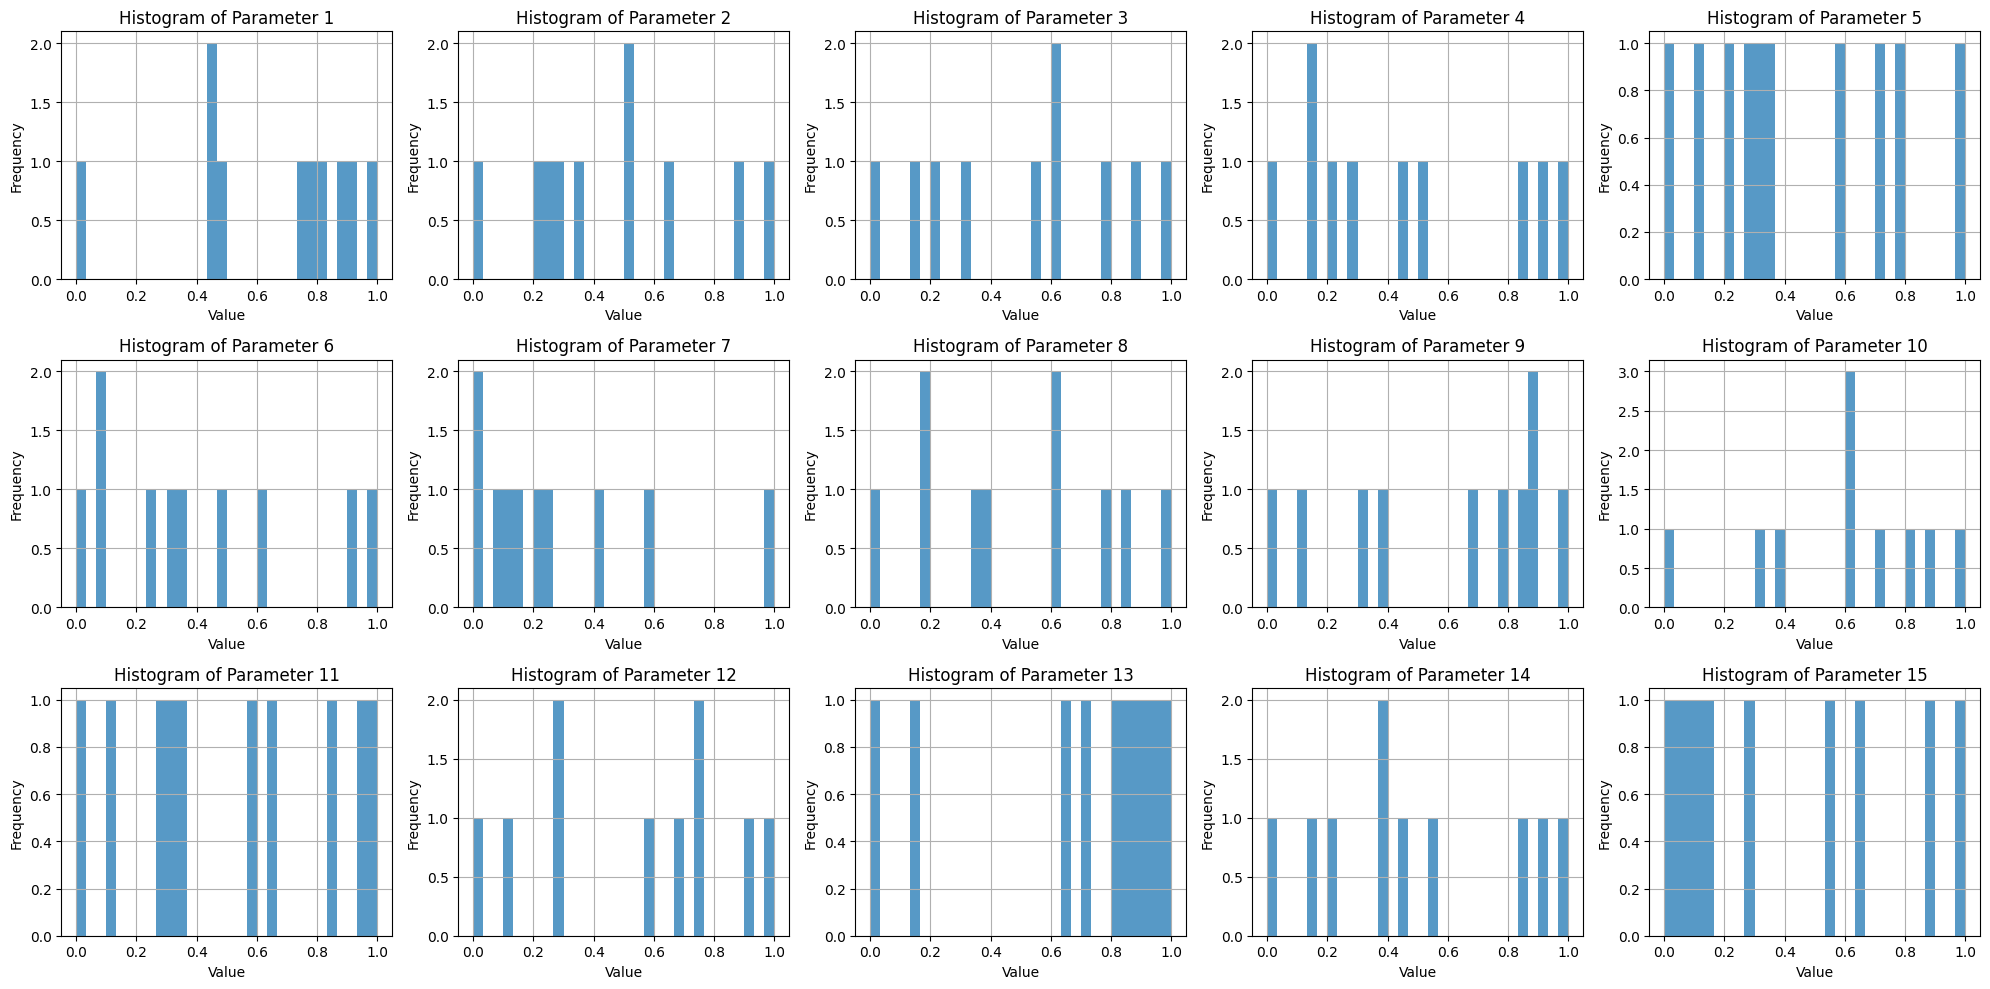

In [8]:
villar.plot_observation(train_data_norm, num_samples =3)
villar.plot_prior(train_theta_norm)

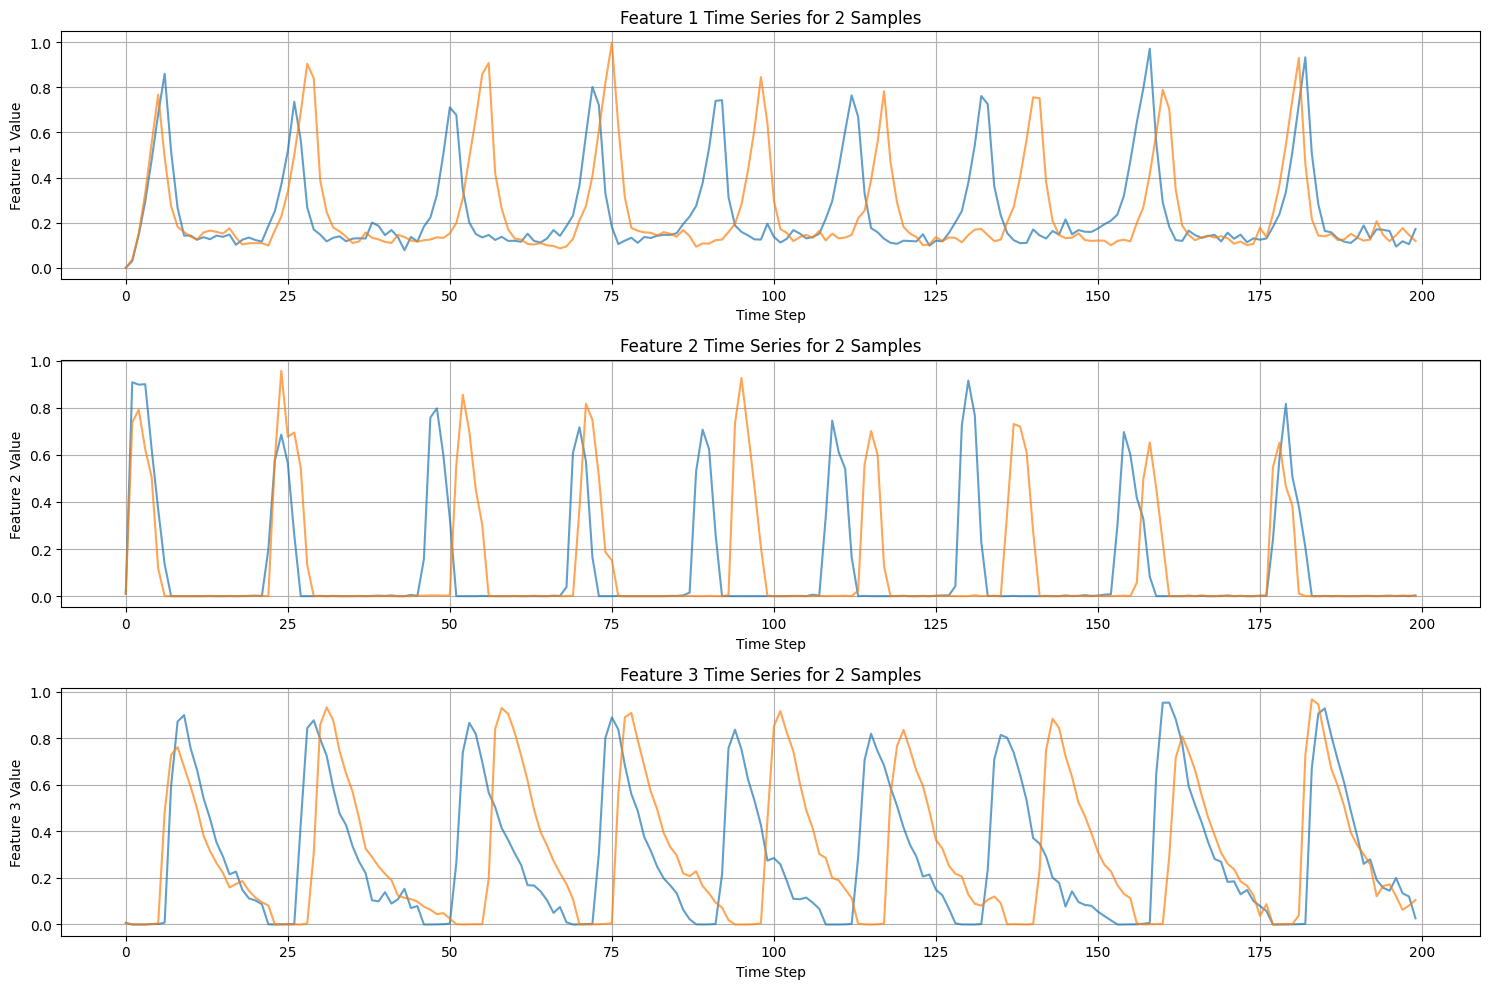

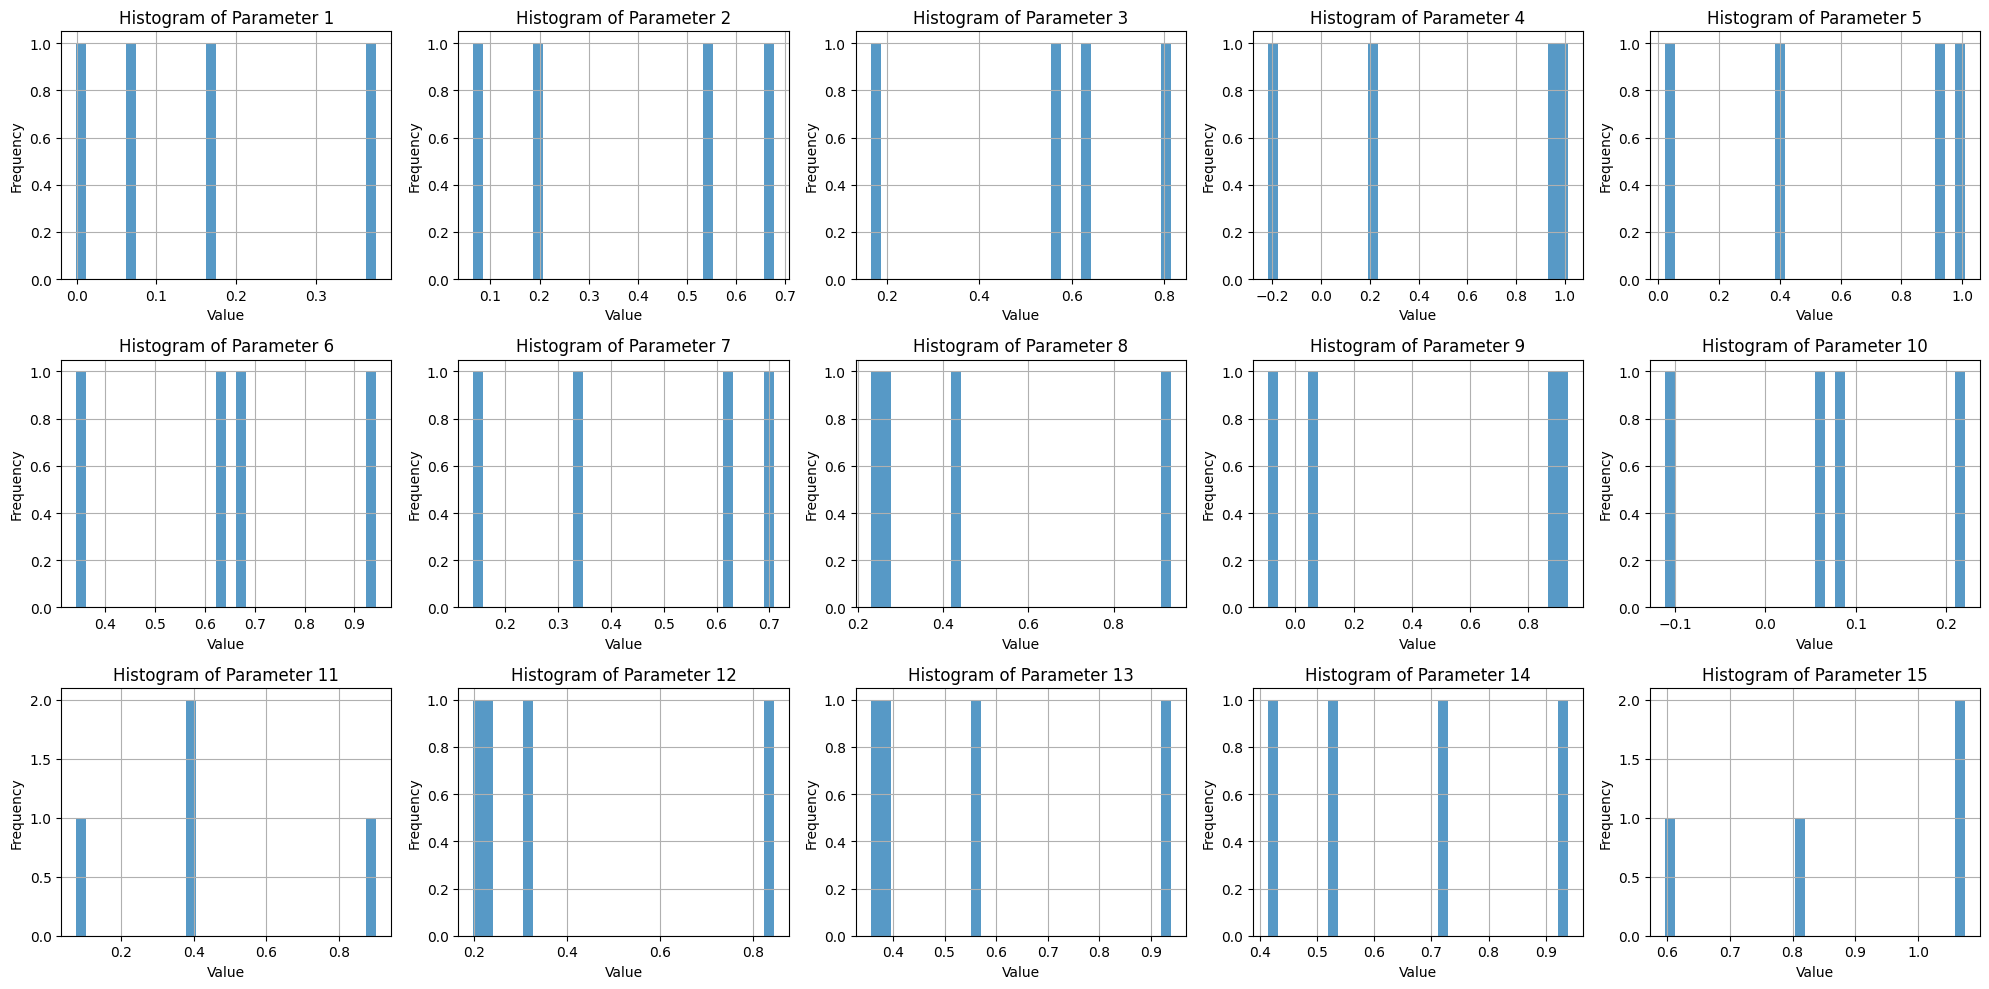

In [9]:
villar.plot_observation(val_data_norm, num_samples =2)
villar.plot_prior(val_theta_norm)

# Define the CVAE Network

In [10]:
# Instantiate the CNN_CVAE model
input_dim = 15  # Example input dimension
latent_dim = 200  # Example latent space dimension
conditional_dim = 3  # Based on Nx3x200 conditional input
encoder_hidden_dims = [512,512]  # Example hidden dimensions for the encoder
sequence_length = 200  # Length of sequences in the conditional input
conv_output_channels = [64, 32]  # Channels in each Conv1D layer for the decoder
kernel_sizes = [3, 3]  # Kernel sizes for the Conv1D layers in the decoder
output_channels = 3  # Matching the original conditional input's channels



network = CNN_CVAE(
    input_dim=input_dim,
    latent_dim=latent_dim,
    conditional_dim=conditional_dim,
    encoder_hidden_dims=encoder_hidden_dims,
    decoder_hidden_dims=[],  # Assuming this is not used in the provided structure
    sequence_length=sequence_length,
    conv_output_channels=conv_output_channels,
    kernel_sizes=kernel_sizes,
    activation_fn= nn.LeakyReLU(0.1),
    w_recon=1.0,
    w_misfit=1.0,
    kld=1.0
)

optimizer = optim.AdamW(network.parameters(), lr=1e-3)

# train_dataset = TensorDataset(train_data_norm, train_theta_norm)
# val_dataset = TensorDataset(val_data_norm, val_theta_norm)

# train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
# validation_loader = DataLoader(dataset=val_dataset, batch_size=128, shuffle=False)

print(network)

CNN_CVAE(
  (encoder): Encoder(
    (layers): Sequential(
      (0): Linear(in_features=15, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.1)
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): LeakyReLU(negative_slope=0.1)
    )
    (fc_mean): Linear(in_features=512, out_features=200, bias=True)
    (fc_logvar): Linear(in_features=512, out_features=200, bias=True)
  )
  (decoder): CNN_Decoder(
    (fc_expand): Linear(in_features=200, out_features=200, bias=True)
    (conv_layers): ModuleList(
      (0): Conv1d(4, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): Conv1d(64, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    )
    (output_layer_1): Linear(in_features=6400, out_features=15, bias=True)
    (output_layer_2): Conv1d(32, 3, kernel_size=(1,), stride=(1,))
  )
)


In [11]:
network.train_model(train_loader=train_loader,
                    validation_loader= validation_loader,
                    optimizer=optimizer,
                    epochs=20,
                    num_cycles = 1,
                    theta_normalizer=theta_normalizer,
                    data_normalizer=data_normalizer,
                    
                    patience=100)

NameError: name 'train_loader' is not defined

In [ ]:
network.plot_loss()

# Inference

In [ ]:
post = network.get_posterior(observed_data= observed_data, num_samples=10000)
post = theta_normalizer.inverse_transform(post)


In [ ]:
#gk_dist.plot_posterior(post)

In [ ]:
gk_dist.posterior_hist(post)